In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
nhefs = pd.read_excel('NHEFS.xls')

In [3]:
nhefs.head()

,seqn,qsmk,death,yrdth,modth,dadth,sbp,dbp,sex,age,...,birthcontrol,pregnancies,cholesterol,hightax82,price71,price82,tax71,tax82,price71_82,tax71_82
0,233,0,0,NaN,NaN,NaN,175.0,96.0,0,42,...,2,NaN,197.0,0.0,2.183594,1.739990,1.102295,0.461975,0.443787,0.640381
1,235,0,0,NaN,NaN,NaN,123.0,80.0,0,36,...,2,NaN,301.0,0.0,2.346680,1.797363,1.364990,0.571899,0.549316,0.792969
2,244,0,0,NaN,NaN,NaN,115.0,75.0,1,56,...,0,2.0,157.0,0.0,1.569580,1.513428,0.551270,0.230988,0.056198,0.320251
3,245,0,1,85.0,2.0,14.0,148.0,78.0,0,68,...,2,NaN,174.0,0.0,1.506592,1.451904,0.524902,0.219971,0.054794,0.304993
4,252,0,0,NaN,NaN,NaN,118.0,77.0,0,40,...,2,NaN,216.0,0.0,2.346680,1.797363,1.364990,0.571899,0.549316,0.792969


In [4]:
c_list = [c for c in nhefs.columns if nhefs[c].nunique()>3]

In [5]:
def convert_to_normal(df, m):
    min_value = min(df)  
    if min_value<=0:
        df = df - min_value+1
    if m == 'log':
        return np.log(df)
    elif m == 'boxcox':
        fitted, lambda_value = boxcox(df)
        return fitted

In [6]:
from scipy.stats import shapiro
from scipy.stats import boxcox
for c in c_list:
    try:
        stats, p = shapiro(nhefs[c].dropna())
        if p == 0:
            print(f'{c} is not a continuous variable')
        elif p == 1:
            print(f'{c} has nan values')
        elif p >0.05:
            print(f'{c} have normal distribution with pvalue of {p}')
        else:
            print(f'{c} have non-normal distribution with pvalue of {p}')
            stats, p = shapiro(convert_to_normal(nhefs[c].dropna(),'boxcox'))    
            if p > 0.05:
                print(f'      transformed({c}) have normal distribution with pvalue of {p}')
#             else: 
#                 print(f'      log({c}) have non-normal distribution with pvalue of {p}')
    except Exception as e:
        print(e)

seqn have non-normal distribution with pvalue of 9.439453243646321e-35
yrdth have non-normal distribution with pvalue of 1.164404017650611e-09
modth have non-normal distribution with pvalue of 2.3280143437998113e-11
dadth have non-normal distribution with pvalue of 4.703114342419212e-09
sbp have non-normal distribution with pvalue of 6.45380272586709e-20
      transformed(sbp) have normal distribution with pvalue of 0.3076455295085907
dbp have non-normal distribution with pvalue of 3.0910778381354476e-09
age have non-normal distribution with pvalue of 7.984184052812166e-19
income have non-normal distribution with pvalue of 2.829356409830349e-30
marital is not a continuous variable
school have non-normal distribution with pvalue of 1.6159102929002382e-29
education have non-normal distribution with pvalue of 7.040791656879052e-33
ht have non-normal distribution with pvalue of 8.373375237624714e-08
wt71 have non-normal distribution with pvalue of 4.769122746371552e-21
      transformed(wt

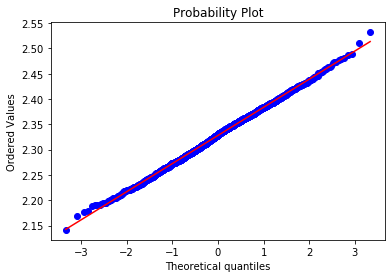

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe867f25e10>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe86801a828>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe867f25b00>],
 'medians': [<matplotlib.lines.Line2D at 0x7fe86801aeb8>],
 'fliers': [],
 'means': []}

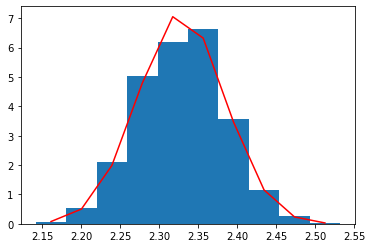

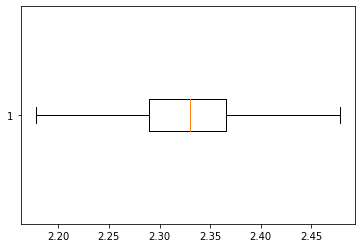

In [8]:
import numpy as np
import scipy.stats as stats
import pylab

data= convert_to_normal(nhefs['wt71'].dropna(), 'boxcox')

## Q-Q plot
stats.probplot(data, dist='norm', plot=pylab)
pylab.show()


## Histgram
(values, bins, _) = plt.hist(data,  density=True)
bin_centers = 0.5*(bins[1:] + bins[:-1])
mu = np.mean(data)
sigma = data.std()

pdf = stats.norm.pdf(x = bin_centers, loc=mu, scale=sigma) #Compute probability density function
plt.plot(bin_centers, pdf, label="PDF",color='red')


## Box plot
fig, ax = plt.subplots()
ax.boxplot(data, showfliers=False, vert=False)

#### Pythonic Tip: Difference between Numpy variance and Pandas variance

Variance is the average squared deviations from the mean, while standard deviation is the square root of this number. Both measures reflect variability in a distribution, but their units differ:

Standard deviation is expressed in the same units as the original values (e.g., minutes or meters).
Variance is expressed in much larger units (e.g., meters squared).

In [9]:
import numpy as np
import pandas as pd

arr = pd.DataFrame([5,3,1,6])
# numpy, population
arr.values.var()
# numpy, sample
arr.values.var(ddof=1)


# pandas, population
arr.var(ddof=0)
# pandas, sample
arr.var()

0    4.916667
dtype: float64

# Overview Guidline
![title](diagram.png)

## 1. Confidence interval of normal distribution

### 1.1. Confidence interval of mean

If sample data is normal or normal-like distributed, we almost always assume t-distribution to compute confidence interval.

- When computing s, correction factor (n−1) is applied to account for sample bias
- As the sample size n increases, the standard error decreases, reducing the range of confidence interval. The more samples we have, the less uncertainty we have with our statistical estimation

#### 1.1.1 formula alculation

In [10]:
len(nhefs), len(data)

(1629, 1629)

In [15]:
alpha =0.05
df = len(data) - 1 # degress of freedom
t = stats.t.ppf(1 - alpha/2, df) # t-critical value for 95%
s = np.std(data, ddof=1) # sample standard deviation 
n = len(data)
se = s / np.sqrt(n) # standard error

In [16]:
lower = np.mean(data) - (t * se)
upper = np.mean(data) + (t * se)

(lower, upper)

(2.325341801600251, 2.3307363990554926)

#### 1.1.2 scipy.stats.t.interval()

In [17]:
stats.t.interval(1 - alpha, 
                 len(data) - 1, 
                 loc=np.mean(data), # mean
                 scale=stats.sem(data)) # standard error

(2.325341801600251, 2.3307363990554926)

## 2. Confidence interval of difference in mean

Notes: Comparing means of more than two samples with ANOVA. Using t-test is not reliable in cases where there are more than 2 samples. If we conduct multiple t-tests for comparing more than two samples, it will have a compounded effect on the error rate of the result.


### 2.1. Independent (unpaired) samples, equal variance - student's t-interval
For example purpose, suppose they're equal variance, but infact they are not.

In [18]:
x1 = convert_to_normal(nhefs['wt82'].dropna(), 'boxcox')
x2 = convert_to_normal(nhefs['wt71'].dropna(), 'boxcox')
x3 = convert_to_normal(nhefs['sbp'].dropna(), 'boxcox')

print(len(x1), len(x2), len(x3))

print(x1.var(ddof=1), x2.var(ddof=1), x3.var(ddof=1))

1566 1629 1552
0.013154497237763327 0.0030806119653617715 6.4701671420617164e-06


In [105]:
alpha = 0.05                                                 # significance level = 5%
n1, n2 = len(x1), len(x2)                                    # sample sizes
s1, s2 = np.var(x1, ddof=1), np.var(x2, ddof=1)              # sample variances
s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2)) # pooled standard deviation
df = n1 + n2 - 2                                             # degrees of freedom
t = stats.t.ppf(1 - alpha/2, df)                             # t-critical value for 95% CI

In [106]:
lower = (np.mean(x1) - np.mean(x2)) - t * np.sqrt(1 / len(x1) + 1 / len(x2)) * s
upper = (np.mean(x1) - np.mean(x2)) + t * np.sqrt(1 / len(x1) + 1 / len(x2)) * s
(lower, upper)

(0.8355354112105238, 0.8479622152254647)

The 95% confidence interval of difference in means has not have 0 within its interval. This means that the null hypothesis, H0:μ1−μ2=0 falls outside the interval and we reject the null hypothesis. 


We conclude that the sample means are significantly different.

OR.. **stats.ttest_ind()**

In [21]:
stats.ttest_ind(x1, x2, equal_var=True)

Ttest_indResult(statistic=265.6230797133454, pvalue=0.0)

### 2.2 Independent (unpaired) samples, unequal variance - Welch's t-interval

When comparing central tendency of normal distributions, it is safer, and therefore recommended to always use Welch's t-test, which assumes unequal variances of samples.

In [22]:
alpha = 0.05                                                       # significance level = 5%
n1, n2 = len(x1), len(x2)                                          # sample sizes
s1, s2 = np.var(x1, ddof=1), np.var(x2, ddof=1)                    # sample variances
df = (s1/n1 + s2/n2)**2 / ((s1/n1)**2/(n1-1) + (s2/n2)**2/(n2-1))  # degrees of freedom
t = stats.t.ppf(1 - alpha/2, df)                                   # t-critical value for 95% CI

In [23]:
lower = (np.mean(x1) - np.mean(x2)) - t * np.sqrt(1 / len(x1) + 1 / len(x2)) * s
upper = (np.mean(x1) - np.mean(x2)) + t * np.sqrt(1 / len(x1) + 1 / len(x2)) * s
(lower, upper)

(0.837896865846161, 0.8456007605898275)

OR.. **stats.ttest_ind()**

In [24]:
stats.ttest_ind(x1, x2, equal_var=False)

Ttest_indResult(statistic=262.39174818167413, pvalue=0.0)

### 2.3. Dependent (paired) samples - Paired t-interval

A school develops a tutoring program to improve the SAT scores of high school students. A school requires students to take tests before & after tutoring, and checks if the tutoring had a significant impact on the SAT scores of students. Because the test subjects are compared to themselves, not anyone elses, the measurements taken before & after the training are not independent.

In [25]:
x1 = np.array([1480, 1280, 890, 340, 1550, 1230, 1010, 1590, 1390, 980])
x2 = np.array([1510, 1460, 1320, 700, 1550, 1420, 1340, 1570, 1500, 1300])

alpha = 0.05                        # significance level = 5%
d_bar = np.mean(x1 - x2)            # average of sample differences
s_d = np.std(x1 - x2, ddof=1)       # sample standard deviation of sample differences
n = len(x1)                         # sample size
df = n - 1                          # degrees of freedom
t = stats.t.ppf(1 - alpha/2, df)    # t-critical value for 95% CI

lower = d_bar - t * s_d / np.sqrt(n)
upper = d_bar + t * s_d / np.sqrt(n)
(lower, upper)

(-308.64567899681356, -77.35432100318641)

The 95% confidence interval of difference in means for dependent samples does not have 0 within its interval. This means that the null hypothesis, H0:μ1−μ2=0 in figure (9), does not fall within the interval. Instead, our estimation falls within the 2.5% outlier zone on the left, We reject the null hypothesis.

OR..**stats.ttest_rel()**

In [26]:
stats.ttest_rel(x1, x2)

Ttest_relResult(statistic=-3.7752930865755987, pvalue=0.004380623368522125)

**Notes:** The above hypothesis testing answers the question of "Did this tutoring program had a significant impact on the SAT scores of students?". However, in cases like this, a more intuitive question is "Did this tutoring program significantly improve the SAT scores of students?" The former uses two-tailed test, and the latter uses one-tailed test, and the procedures for them are a little different.

## 3. Confidence interval of variance
Confidence interval of variance is used to estimate the population variance from sample data and quantify the related uncertainty.  C.I. of variance is seldom used by itself, but rather used in conjunction with f-test, which tests equality of variances of different populations.

- When sample is **normal**, you can use **f-test or Barlett's test** to check equality of variances. 
- When the sample is **not normal**, use non-parametric alternative like **Levene's test**.

In [27]:
arr = nhefs['income']
alpha = 0.05               # significance level = 5%
n = len(arr)               # sample sizes
s2 = np.var(arr, ddof=1)   # sample variance
df = n - 1                 # degrees of freedom

In [29]:
upper = (n - 1) * s2 / stats.chi2.ppf(alpha / 2, df)
lower = (n - 1) * s2 / stats.chi2.ppf(1 - alpha / 2, df)
(lower, upper)

(6.629926567364578, 7.606693587382899)

The output suggests that the 95% confidence interval of variance is betwteen 6.6 and 7.6

Using f_oneway
https://www.pythonfordatascience.org/anova-python/#anova_scipy_stats

In [30]:
from scipy.stats import f_oneway

x1 = convert_to_normal(nhefs['wt82'].dropna(), 'boxcox')
x2 = convert_to_normal(nhefs['wt71'].dropna(), 'boxcox')

# x1 = np.array([1480, 1280, 890, 340, 1550, 1230, 1010, 1590, 1390, 980])
# x2 = np.array([1510, 1460, 1320, 700, 1550, 1420, 1340, 1570, 1500, 1300])

F, p = f_oneway(x1, x2)
p

0.0

## 4. Bootstrap
### 4.1 Basic bootstrap

In [88]:
# prepare original sample data

np.random.seed(42)
n = 500
arr = np.random.normal(loc=0.15, scale=2, size=n)# 0.022
# single bootstrapping

single_boot = np.random.choice(arr, len(arr))

In [89]:
len(single_boot)

500

### 4.2 Basic bootstrap with Monte-Carlo method
Bootstrap is often combined with Monte-Carlo method to quantify uncertainty in statistics (ex: mean, median, variance, etc...). It just means that you generate multiple instances of the single_boot object above.

In [90]:
# 1000 monte-carlo bootstrapping

r = 1000
monte_boot = [np.random.choice(arr, len(arr)) for _ in range(r)]

In [91]:
len(monte_boot), len(monte_boot[0])

(1000, 500)

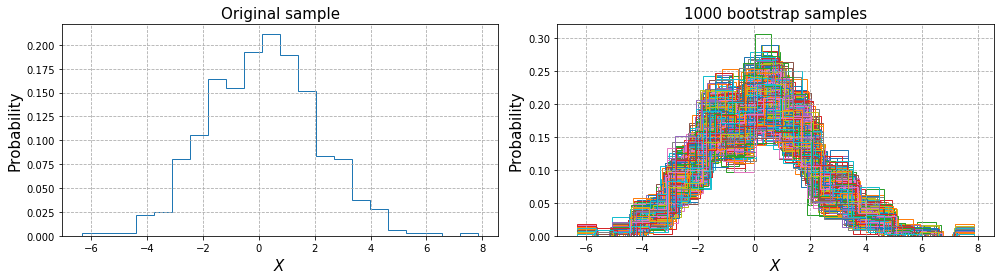

In [92]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].hist(arr, bins='auto', range=(min(arr), max(arr)), histtype='step', density=True)
for boot in monte_boot:
    axes[1].hist(boot, bins='auto', range=(min(boot), max(boot)), histtype='step', density=True)

for ax in axes:
    ax.grid(True, linestyle='--', color='#acacac')
    ax.set_ylabel('Probability', fontsize=15)
    ax.set_xlabel('$X$', fontsize=15)
axes[0].set_title('Original sample', fontsize=15)
axes[1].set_title('% s bootstrap samples' % r, fontsize=15)
fig.tight_layout()

### 4.3 Basic bootstrap with Monte-Carlo method + constructing confidence intervals

Note: this is a test, bootstrap results changres as batch and size increase

In [111]:
import numpy as np

# 100 monte-carlo bootstrapping

def bootstrap_f(r):
    monte_boot_mean = [np.mean(np.random.choice(arr, len(arr))) for _ in range(r)]
    monte_boot_median = [np.median(np.random.choice(arr, len(arr))) for _ in range(r)]
    monte_boot_std = [np.std(np.random.choice(arr, len(arr)), ddof=1) for _ in range(r)]
    monte_boot_skew = [stats.skew(np.random.choice(arr, len(arr))) for _ in range(r)]
    monte_boot_kurtosis = [stats.kurtosis(np.random.choice(arr, len(arr))) for _ in range(r)]
    # use the 25th value and the 975th value of the ranked differences as boundaries of the 95% confidence interval. 
    print(np.percentile(monte_boot_mean, 2.5), np.percentile(monte_boot_mean, 97.5))

In [112]:
bootstrap_f(50)

bootstrap_f(5000)

0.029960838123527265 0.3544803584181303
-0.013764925273088346 0.33235367575342445


We cannot see a difference here as batch increase

In [113]:
import numpy as np

# 100 monte-carlo bootstrapping

r = 5000
monte_boot_mean = [np.mean(np.random.choice(arr, 50)) for _ in range(r)]
monte_boot_median = [np.median(np.random.choice(arr, 50)) for _ in range(r)]
monte_boot_std = [np.std(np.random.choice(arr, 50), ddof=1) for _ in range(r)]
monte_boot_skew = [stats.skew(np.random.choice(arr, 50)) for _ in range(r)]
monte_boot_kurtosis = [stats.kurtosis(np.random.choice(arr, 50)) for _ in range(r)]

print(np.percentile(monte_boot_mean, 2.5), np.percentile(monte_boot_mean, 97.5))

-0.37797310128294825 0.7027664595588564


We see a difference as size decrease, the range of mean is wider,

then plot them out

In [54]:
def custom_stats(arr):
    return sum(arr) / len(arr) + 0.002

monte_boot_custom = [custom_stats(np.random.choice(arr, len(arr))) for _ in range(r)]

Text(0.5, 0.98, 'Monte-Carlo bootstrap uncertainty modeling')

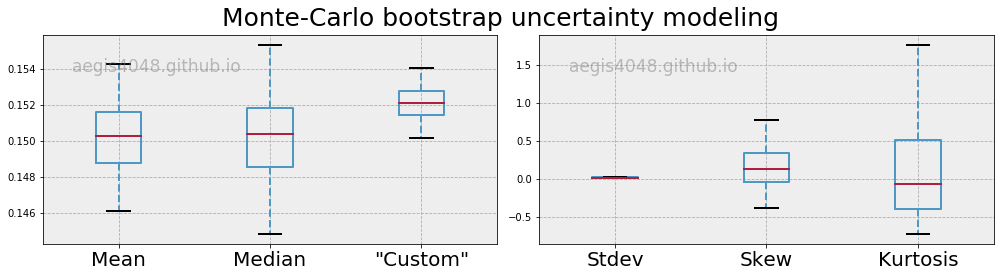

In [70]:
# plotting
styling = {'sym': '',
           'whis': [2.5, 97.5],
           'showfliers': False,
           'vert': True,
           'boxprops': dict(linewidth=2.0, color='#4e98c3'),
           'whiskerprops': dict(linewidth=2.0, color='#4e98c3', linestyle='--'),
           'capprops': dict(linewidth=2.0, color='k'),
           'medianprops': dict(linewidth=2.0, color='#ad203e')
}

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].boxplot([monte_boot_mean, monte_boot_median, monte_boot_custom], **styling)
axes[1].boxplot([monte_boot_std, monte_boot_skew, monte_boot_kurtosis], **styling)
axes[0].set_xticklabels(['Mean', 'Median', '"Custom"'], fontsize=20)
axes[1].set_xticklabels(['Stdev', 'Skew', 'Kurtosis'], fontsize=20)
for ax in axes:
    ax.set_facecolor('#eeeeee')
    ax.grid(True, linestyle='--', color='#acacac')
    ax.text(0.25, 0.85, 'aegis4048.github.io', fontsize=17, ha='center', va='center',
            transform=ax.transAxes, color='grey', alpha=0.5);
fig.tight_layout(rect=[0, 0.03, 1, 0.92])
fig.suptitle('Monte-Carlo bootstrap uncertainty modeling', fontsize=25)

### 5. Confidence interval of non-normal distribution

One of the biggest assumptions in the field of statistics is the assumption of **normality**. It is important because of the two key characteristics of normal distribution: **symmetry (low skew)** and **light/short-tails (low kurtosis)**.
- Symmetry is important because many statistical techniques use ± standard error methods that assume equal properties from both sides of a distribution. 
- Heavy-tailedness is detrimental in inferencing population parameters because heavy tailed distributions (ex: log-normal distribution, cauchy distribution) have non-negligible number of extreme data points that may introduce bias in your samples 

### 5.1 Problems of non-normal distribution and central tendency
#### 5.1.1 Problems with Skewness(asymmetry)
- We could use median or rather than mean as a measure o fcentral tendency of a skewed distribution.
- There are many parametric alternatives that account for skewness, such as skewness-adjusted t-test and Box-Cox transformation.

#### 5.1.2 Problems with kurtosis (heavy-tails)
Unlike skewness, which can be relatively easily adjusted, heavy-tails can be very painful in inferencial statistics. When a distribution has heavy-tails, it means that the sample has extreme data points that can introduce bias to statistical inferences.

In finance, such property is translated into high risk & unpredictability, which is modeled by **Cauchy distributions**.

Practitioners often neglect the distinction between light- vs heavy-tail because they visually don't look very different when plotted in PDF. This is a big **misconception**.

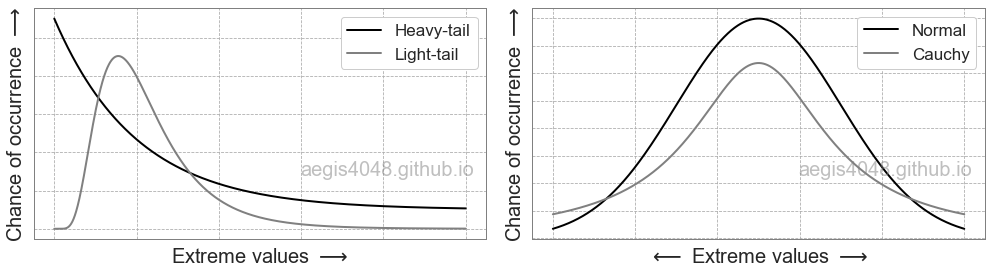

In [3]:
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-whitegrid')

x = np.linspace(0, 5, 1000)
y1 = stats.expon.pdf(x, scale=1) + 0.1
y2 = stats.lognorm.pdf(x, 0.5, loc=-0.001, scale=1)
y3 = stats.norm.pdf(x, loc=2.5)
y4 = stats.cauchy.pdf(x, loc=2.5)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(x, y1, label='Heavy-tail', color='k', linewidth=2)
axes[0].plot(x, y2, label='Light-tail', color='grey', linewidth=2)
axes[0].set_xlabel(r'Extreme values $\longrightarrow$', fontsize=20)
axes[1].plot(x, y3, label='Normal', color='k', linewidth=2)
axes[1].plot(x, y4, label='Cauchy', color='grey', linewidth=2)
axes[1].set_xlabel(r'$\longleftarrow$ Extreme values $\longrightarrow$', fontsize=20)

for ax in axes:
    ax.set_ylabel(r'Chance of occurrence $\longrightarrow$', fontsize=20)
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.legend(fontsize=17, loc='upper right', framealpha=1, frameon=True)
    ax.grid(True, linestyle='--', color='#acacac')
    _ = [spine.set_edgecolor('grey') for spine in ax.spines.values()]
    ax.text(0.78, 0.3, 'aegis4048.github.io', fontsize=20, ha='center', va='center',
            transform=ax.transAxes, color='grey', alpha=0.5)

fig.tight_layout()

#### Treatment to heavy tailed distribution:

First step: map the distribution to a normal distribution using transformation techniques. However, the heavy-tails may still be present even after the presentation.

If you are running a regression model, you may simply **remove** the tails and see if there's any performance improvement. 

In terms of inferencial statistics, naive removal maybe detrimental, as it completely ignores the extremity in your population. Sometimes the heavy-tails may suggest amalgamation of two distinct populations, in which case you may need to **separate them apart** before running your model.

#### 5.1.3 Problems with multi-modal distributions


In case of multi-modal distributions, reporting the mean, median, or mode can be uninformative at all, as none of them describes the central location of populations. While it is possible to compute the confidence interval of statistics using non-parameteric methods like bootstrap, it is *useless*. 

### 5.2 Robustness of confidence intervals to non-normality
Confidence interval of mean is robust to mild deviation from normality. This means that hypothesis tests that rely on the means (ex: t-test) are also robust to mild deviation from non-normality. There are a few variations of t-test that deals with mild non-normality (ex: **skewness-adjusted t-statistic**).

*Confidence interval of variance* is **VERY sensitive** to even small deviation from non-normality. 

When sample is **normal**, you can use **f-test or Barlett's test** to check equality of variances. When the sample is **not normal**, use non-parametric alternative like **Levene's test**.


How do WE know the severity of deviation from normality? Q-Q plots
![title](conf_int_qq_plots.png)

### 5.3 Transform to normal distribution: Box-Cox

Box-Cox transformation is a type of **power transformation** to convert non-normal data to normal data by raising the distribution to a power of lambda (λ). The algorithm automatically solves for λ that best transforms a distribution into a normal distribution. The exception to this rule is when the λ is 0 - log will be taken to the distribution — log(Y). 
 
**Not all transforms work perfectly, especially in case of heavy tails.**

Visualize your transformed histrogram, and the Q-Q plot to evaluate the performance of the transform. If the transform did not mitigate the skewness (this is rare), you will have to look for non-parametric alternatives, like bootstrap 


**All data to be positive and greater than 0 (Y > 0)** 

Box-Cox transformation does not work if data is smaller than 0. This can easily be fixed by adding a constant (C) that will make all your data greater than zero: Y' = (Y+C)^λ

#### 5.3.1 SciPy Implementation

Lets take a look of the original data and its distribution

In [14]:
x= nhefs['wt71']

,count,mean,std,min,25%,50%,75%,max,Median
wt71,1629.0,71.05213,15.72959,36.17,59.65,69.4,79.95,169.19,69.4


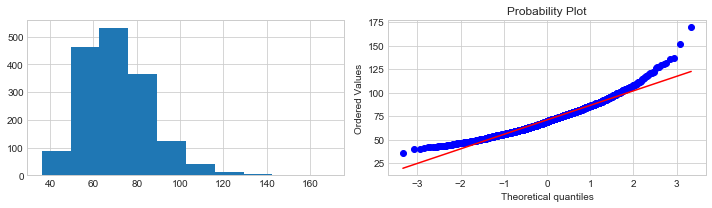

In [19]:
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# plot
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].hist(x)
stats.probplot(x, dist=stats.norm, plot=axes[1])
fig.tight_layout()

# summary statistics
df = pd.DataFrame(x).describe().T
df['Median'] = np.median(x)
df

The distribution seems to be non-normal. The mean is 71, and the median is 69. Let's transform this data into a normal distribution with Box-Cox transform.

,count,mean,std,min,25%,50%,75%,max,Median
0,1629.0,2.328039,0.055503,2.141464,2.28949,2.329845,2.365852,2.531802,2.329845


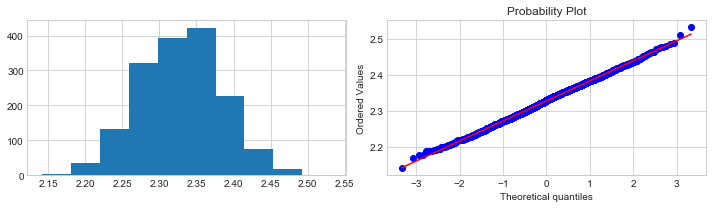

In [20]:
# box-cox transform
xt, lmbda = stats.boxcox(x)

# plot
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].hist(xt)
stats.probplot(xt, dist=stats.norm, plot=axes[1])
fig.tight_layout()

# summary statistics
df = pd.DataFrame(xt).describe().T
df['Median'] = np.median(xt)
df

The transformation seemed to work well. 

Then We proceed to calculate the confidence interval of your statistic. In this case, we compute the 95% C.I. of mean

In [24]:
lo_xt, hi_xt = stats.t.interval(1 - 0.05, 
                                len(xt) - 1, 
                                loc=np.mean(xt), 
                                scale=stats.sem(xt, ddof=1))

(lo_xt, hi_xt)

(2.325341801600251, 2.3307363990554926)

Note that the above C.I. of mean is in the transformed scale. We need to apply **back-transform** to put it back to its original scale. 

In [26]:
from scipy.special import inv_boxcox
# inverse transform
lo_x, hi_x = inv_boxcox(lo_xt, lmbda), inv_boxcox(hi_xt, lmbda)

(lo_x, hi_x)

(68.21256152942284, 69.63835662177185)

The result is consistent with the statement in the WARNING above: "when the transformed variable is symmetric, taking an inverse of the **transformed mean** yields the **median** of the original variable."

We can also try non-parametric alternative bootstrap to obtain the C.I. of median of the non-normal distribution. 

In [27]:
iteration = 100000

boot_median = [np.median(np.random.choice(x, len(x))) for _ in range(iteration)]
lo_x_boot = np.percentile(boot_median, 2.5)
hi_x_boot = np.percentile(boot_median, 97.5)

(lo_x_boot, hi_x_boot)

(68.27, 70.53)

#### 5.3.2 SScikit-Learn implementation

Recall that x is an 1-D array. Since Scikiy-Learn's Box-Cox expects 2-D array as input, 

,count,mean,std,min,25%,50%,75%,max,Median
0,1629.0,2.328039,0.055503,2.141464,2.28949,2.329845,2.365852,2.531802,2.329845


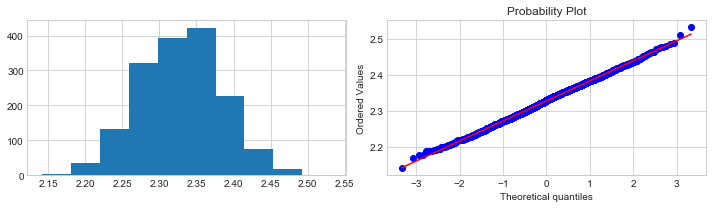

In [30]:
# convert data type
x_mat = np.asmatrix(x).T

from sklearn.preprocessing import PowerTransformer

# box-cox transform
pt = PowerTransformer(method='box-cox', standardize=False)
pt.fit(x_mat)
xt = pt.transform(x_mat)

# convert data type for plotting
xt = xt.flatten()

# plot
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].hist(xt)
stats.probplot(xt, dist=stats.norm, plot=axes[1])
fig.tight_layout()

# summary statistics
df = pd.DataFrame(xt).describe().T
df['Median'] = np.median(xt)
df

In [32]:
# 95% confidence interval of mean in a transformed scale
lo_xt, hi_xt = stats.t.interval(1 - 0.05, 
                                len(xt) - 1, 
                                loc=np.mean(xt), 
                                scale=stats.sem(xt))
print(lo_xt, hi_xt)
# convert data type
lo_xt_mat = np.asmatrix(lo_xt)
hi_xt_mat = np.asmatrix(hi_xt)

# inverse transform
hi_x = pt.inverse_transform(hi_xt_mat)[0][0]
lo_x = pt.inverse_transform(lo_xt_mat)[0][0]

(lo_x, hi_x)

2.325341801600251 2.3307363990554926


(68.21256152942289, 69.63835662177183)

### 5.4 Non-parametric alternative: Bootstrap
Let's take a deeper look at the robustness of parametric vs non-parametric methods for different distributions by running simulations. We compute the confidence interval of mean and variance. CI of mean is known to be resistent to deviation from normality, while CI of variance is very sensitive. 

![title](conf_int_coverage.png) 

Hightlights

1. Some statistics are sensitive to deviation from normality
2. Parametric methods acquire 95% nominal coverage rate ONLY under normality
3. Making an inference about heavy-tailed distribution is difficult
4. Bootstrap outperforms parametric method under non-normality
5. Parametric method outperforms non-parametric method under normality
6. Non-parametric methods yield "approximate" solutions with smaller risk

## Reference
https://aegis4048.github.io/comprehensive_confidence_intervals_for_python_developers#5.4-Non-parametric-alternative:-Bootstrap